In [1]:
# Wait for 4 progress bars to complete
from analysis_lib import *
from tqdm import tqdm
%matplotlib inline
from itertools import product
from functools import reduce

# numbers for data sources
sources = {
    "accidents": 0,
    "subways": 1,
    "sounds": 2,
    "taxis": 3,
    "all": None,
    "norm-all": None
}



def select(kind):
    '''Puts 24D vectors corresponding to the hourly frequency of events 
    of a specified type for each day into the global points list, along
    with their corresponding dates (using Day objects).
    '''
    global points
    if kind in ['all', 'norm-all']:
        selection = [sources[i] for i in sources]
    else:
        selection = [sources[kind]]
    points = [i for i in cached if i.source in selection]
    # if "all" or "norm-all" is specified, use greater than 24D vector
    if kind in ['all', 'norm-all']:
        tmp = []
        for week, day in product(range(53), range(7)):
            toadd = [i for i in points if i.num == day and i.week == week]
            if not toadd: continue
            if kind == 'all':
                newvec = reduce(lambda a, b: np.array(list(a) + list(b)), \
                                [i.vec for i in toadd])
            else:
                newvec = reduce(lambda a, b: np.array(list(a) + list(b)), \
                                [norm(i.vec) for i in toadd])
            d = toadd[0]
            tmp.append(Day(newvec, None, d.name, d.num, d.week, None))
        points = [i for i in tmp if i.vec.shape == (96,)]



ModuleNotFoundError: No module named 'analysis_lib'

In [ ]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from itertools import product

def calendar(kind, offset=0):
    '''Make a calendar of the daily distribution of data of type 
    "kind" with an "offset"-hour shift per day. Yellow shows intensity
    and red lines indicate holidays. The numbers represent the total
    number of events on a given day.
    '''
    select(kind)
    
    if kind in ['all', 'norm-all']: return
    def hist(data, title, col, color):
        col.plot(range(24), list(data)[offset:] + list(data)[:offset],
                 color=color)

    fig, ax = plt.subplots(nrows=53, ncols=7, figsize=(20, 40))
    # Get holiday dates
    cur.execute('SELECT date FROM Holidays')
    holiday_dates = cur.fetchall()

    for col, title in zip(ax[0], daylist[1:] + daylist[0:1]):
        col.set_title(title)
    month = 0
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            try:
                [v] = [v for v in points 
                         if v.week == i
                         and v.num == (j + 1) % 7]
                month = int(v.date.split(' ')[0])
                # Scale for shading
                max_mag = max(sum(day.vec) for day in points)
                color = 'blue'
                # Color red if holiday
                for [date] in holiday_dates:
                    [m, d, y] = map(int, date.split("/"))
                    if v.date == f'{m:02} {d:02} {y:04}':
                        color = 'red'
                        
                # Compute shading
                mag = 255 - int(255 * (sum(v.vec) / max_mag) ** 2)
                hist(v.vec, f'{i + 1}-{j}', col, color)
                
                col.spines['top'].set_visible(False)
                col.spines['right'].set_visible(False)
                col.spines['bottom'].set_visible(False)
                col.spines['left'].set_visible(False)
                
                # Add number labels
                col.text(0, 0.5, str(int(sum(v.vec))), transform=col.transAxes, 
                            size=18)
                col.get_xaxis().set_ticks([])
                col.get_yaxis().set_ticks([])
                col.set_facecolor(f'#{"ffff" + f"{mag:02x}"}')
            except Exception as e:
                col.axis('off')
    filename = f'3-{kind}' if not offset else f'4-{kind}+{offset}'
    plt.savefig(f'images/{kind}/{filename}-calendar.png')

# Generate plots for each source with 0 and 6 hour offsets
for kind, offset in tqdm(list(product(sources, [0, 6]))):
    calendar(kind, offset)


In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score

clust_count = {}

def silhouette(name, alg):
    '''Plot silhouette scores by number of clusters for datapoints
    from source "name" using the clustering algorithm "alg"
    '''
    select(name)
    vecs = [norm(v.vec) for v in points]
    plt.figure()
    scores = [silhouette_score(vecs, 
              eval(alg)(n_clusters=i).fit_predict(vecs))
              for i in tqdm(range(2,16))]
    if alg not in clust_count:
        clust_count[alg] = {}
    clust_count[alg][name] = scores.index(max(scores)) + 2
    plt.plot(range(2,16), scores, alpha=0.5)
    plt.scatter(range(2,16), scores)
    plt.title(f"{alg} Silhouette Scores ({name})")
    plt.xlabel("Clusters")
    plt.ylabel("Silhouette")
    system(f'mkdir images/{name}')
    plt.savefig(f'images/{name}/0-{name}-{alg}-silhouette.png')
    
# Compute the silhouette score for each data source 
# for kmeans and hierarchal clustering
for kind in sources:
    silhouette(kind, 'KMeans')
    silhouette(kind, 'AgglomerativeClustering')

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

def cost(name, alg):
    '''Plots the sum of squares cost for the clustering algorithm "alg"
    for the datapoints "name" for 2 <= k <= 16.
    '''
    select(name)
    vecs = [norm(v.vec) for v in points]
    plt.figure()
    scores = [-eval(alg)(n_clusters=i).fit(vecs).score(vecs)
              for i in tqdm(range(2,16))]

    plt.plot(range(2,16), scores, alpha=0.5)
    plt.scatter(range(2,16), scores)
    plt.title(f'{alg} Cost ({name})')
    plt.xlabel('Clusters')
    plt.ylabel('Cost')
    plt.savefig(f'images/{name}/0-{name}-{alg}-cost.png')
    
# Compute costs with kmeans for all data sources
for kind in sources:
    cost(kind, 'KMeans')


In [2]:
from sklearn import manifold
from random import shuffle
from scipy.stats import wasserstein_distance

def embed():
    '''Generate 2D embedding by hellinger distance of 24D global "points" and store in global
    "em". The computed distances and 24D vectors are also stored globally. The SMACOF algorithm 
    is used for the projection.
    '''
    global vecs
    global distances
    global em
    shuffle(points)
    # Use normalized vectors
    vecs = [norm(i.vec) for i in points]
    distances = [[hellinger(a, b) for a in vecs] for b in tqdm(vecs)]

    mds = manifold.MDS(
        n_components=2, 
        max_iter=300,
        eps=1e-9,
        random_state=np.random.RandomState(seed=0), 
        dissimilarity="precomputed", 
        n_jobs=1
    )
    
    em = mds.fit(distances).embedding_

def scatter(x, colors, count, labels):
    palette = np.array(sns.color_palette("hls", count))

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    for col in range(max(colors) + 1):
        ax.scatter(
            [x[i, 0] for i, v in enumerate(colors) if v == col],
            [x[i, 1] for i, v in enumerate(colors) if v == col], 
            lw=0, s=40, alpha=0.7, label=labels[col],
            c=palette[np.array([i for i in colors if i == col]).astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.legend()
    ax.axis('off')
    ax.axis('tight')

  2%|▊                                          | 1/54 [00:08<07:11,  8.14s/it]


NameError: name 'clust_count' is not defined

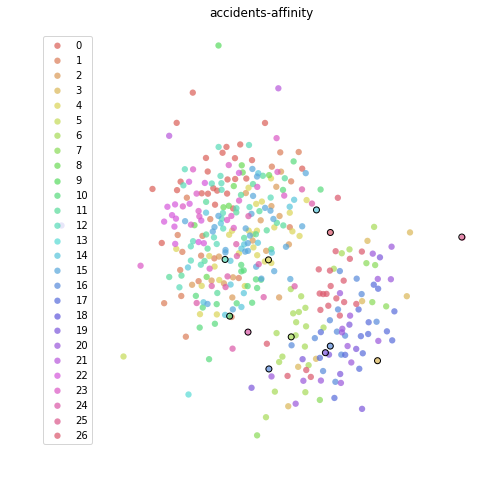

In [3]:
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
import itertools
from matplotlib.patches import Rectangle

plt.close('all')
current_embed = ''

# Placeholder shape for legend
extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

# Clear outliers file (filled by voronoi_day_error category below)
!echo '' > outliers.txt

def make_plot(name, cat):
    '''Given a data source "name" and category "cat", plots the 2D embedding of the 24D 
    vectors in "name" colored based on cat (either a property of the days 
    themselves or a clustering algorithm). Holidays are circled.'''
    labels = {
        'affinity': range(999),
        'hierarchal': range(999),
        'voronoi_day': daylist,
        'week': range(999),
        'voronoi_day_error': ["Incorrect Prediction", "Correct Prediction"],
        'day': daylist,
        'kmeans': range(999),
        'kmeans7': range(999),
        'season': ["Winter", "Spring", 
                  "Summer", "Fall"]
    }[cat]
    
    # Cache embedding between calls
    global current_embed
    if name != current_embed:
        select(name)
        embed()
        current_embed = name
        
    index = sources[f'{name}']
    def dates(m, d, y):
        return [i for i, day in enumerate(points) if day.date == f'{m:02} {d:02} {y:04}']

    affinity = AffinityPropagation(affinity="precomputed", preference=(-(max(map(max, distances)) ** 2)))
    affinity = affinity.fit_predict((-1) * np.array(distances))[:]
    
    if cat == "voronoi_day":
        centers = [np.mean(np.array(
                       [j.vec for j in points if j.num == i]), axis=0)
                       for i in range(7)]
        voronoi_day = [[np.linalg.norm(i.vec - j) for j in centers] for i in points]
        voronoi_day = [i.index(min(i)) for i in voronoi_day]
        acc = sum(1 for a, b in zip(voronoi_day, [i.num for i in points]) if a == b) / len(points)
        
    if cat == "voronoi_day_error":
        centers = [np.mean(np.array(
                       [j.vec for j in points if j.num == i]), axis=0)
                       for i in range(7)]
        voronoi_day_error = [[np.linalg.norm(i.vec - j) for j in centers] for i in points]
        voronoi_day_error = [i.index(min(i)) for i in voronoi_day_error]
        acc = sum(1 for a, b in zip(voronoi_day_error, [i.num for i in points]) if a == b) / len(points)
        voronoi_day_error = [1 if a == b else 0 for a, b in zip(voronoi_day_error, [i.num for i in points])]
        
        # Write points which are not in the correct voronoi cell to a text file
        with open('outliers.txt', 'a') as file:
            file.write(name + "\n")
            for k in [i.date for i, j in zip(points, voronoi_day_error) if j == 1]:
                file.write(str(k) + "\n")
            file.write("\n")

    if cat == "kmeans":
        n_clust = clust_count["KMeans"][name]
        kmeans = KMeans(n_clusters=n_clust).fit_predict(vecs)
        
    if cat == "kmeans7":
        n_clust = 7
        kmeans7 = KMeans(n_clusters=n_clust).fit_predict(vecs)
        
    if cat == "hierarchal":
        n_clust = clust_count["AgglomerativeClustering"][name]
        hierarchal = AgglomerativeClustering(n_clusters=n_clust).fit_predict(vecs)
        
    day = [i.num for i in points]
    week = [i.week for i in points]
    season = [((i.week + 3) % 52) // 13 for i in points]

    # Get variable corresponding to requested category
    using = eval(cat)
    count = len(set(using))

    selected = []
    
    # Circle federal and jewish holidays
    cur.execute('SELECT date FROM Holidays')
    for [date] in cur.fetchall():
        [m, d, y] = map(int, date.split("/"))
        selected += dates(m, d, y)
        
    scatter(em, np.array(using), count, labels)
    res = [em[i] for i in selected]
    plt.scatter([x for [x, y] in res], 
            [y for [x, y] in res],
            facecolors='none', 
            edgecolors='black',
            linewidth=1)
    l1 = plt.legend(loc='center left')
    
    # Show proportion of points that lie outside of their voronoi cells
    if cat in ['voronoi_day', 'voronoi_day_error']:
        l2= plt.legend([extra], [f"Accuracy = {acc}"], loc='upper left')
        plt.gca().add_artist(l1)
        plt.gca().add_artist(l2)
    
    plt.title(f'{name}-{cat}')
    file = f'{name}-{cat}'
    system(f'mkdir images/{name}')
    plt.savefig(f"images/{name}/2-{file}.png", dpi=120)

# For each data source, plot the 2D projection of each event's 24D vector, using the coloring
# schemes below
for name, cat in tqdm(list(itertools.product(sources, 
                                    ['affinity',  # Color by the clustering produced by the
                                                  # affinity propagation algorithm
                                     
                                     'hierarchal', # Color by hierarchal clustering algorithm, with
                                                   # number of clusters decided by max silhouette score
                                     
                                     'voronoi_day', # Color by dividing data into voronoi cells 
                                                    # centered on the means of the sets of each 24D 
                                                    # vector corresponding to a single day of the week. 
                                     
                                     'voronoi_day_error', # Color each point by weather it was
                                                          # put in its weekday's mean's voronoi cell,
                                                          # displaying the proportion that were (accuracy),
                                                          # and writing outliers to outliers.txt
                                     'day', # Color by day of the week
                                         
                                     'week', # Color by week of the year
                                     
                                     'kmeans', # Color by kmeans clustering algorithm, with
                                               # number of clusters decided by max silhouette score
                                     
                                     'kmeans7', # Use 7 clusters for kmeans
                                     
                                     'season', # Color by season of year
                                    ]))):
    make_plot(name, cat)
    

100%|███████████████████████████████| 131769/131769 [00:05<00:00, 24202.12it/s]


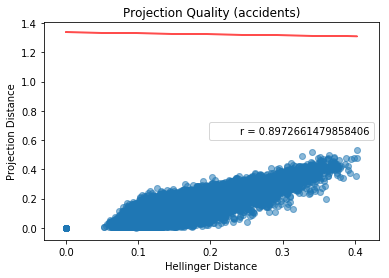

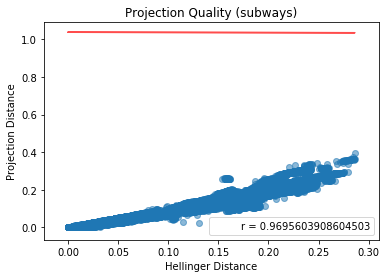

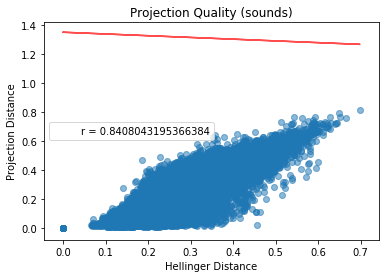

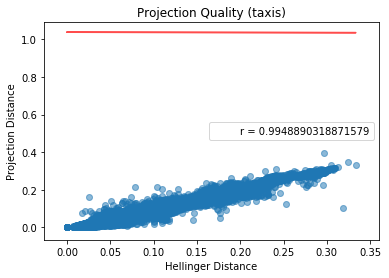

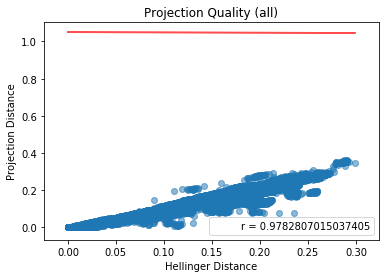

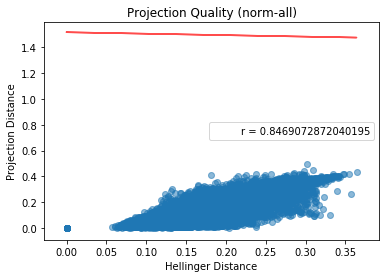

In [4]:
from math import sqrt
import itertools
from matplotlib.patches import Rectangle

def projection(name):
    '''Show quality of projection of data source "name" by plotting 24D hellinger 
    distance vs the 2D distances.'''
    select(name)
    embed()
    scatpts = []

    def distance(a, b):
        return sqrt(sum((i - j) ** 2 for i, j in zip(a, b)))

    for (i1, i2), (j1, j2) in \
tqdm(list(itertools.product(list(zip(em, vecs)), zip(em, vecs)))):
        scatpts.append([hellinger(i2, j2), distance(i1, j1)])
            
    a, b = np.polyfit(*zip(*scatpts), 1)
    r = np.corrcoef(*zip(*scatpts))[1, 0]
    # Placeholder for correlation coefficient
    extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    fit = [a + b * i for i in list(zip(*scatpts))[0]]
    
    plt.figure()
    plt.legend([extra], [f"r = {r}"])
    plt.scatter(*zip(*scatpts), alpha=0.3)
    plt.plot(list(zip(*scatpts))[0], fit, color="r", alpha=0.7)
    plt.title(f"Projection Quality ({name})")
    plt.xlabel("Hellinger Distance")
    plt.ylabel("Projection Distance")
    plt.savefig(f'images/{name}/1-{name}-projection.png')

# Show projection quality for every data source
for kind in sources:
    projection(kind)